In [317]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import gymnasium

from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Define a PPO architecture

In [318]:
class ActorPPO(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 32)
        self.actor = nn.Linear(32, 2)
    
    def forward(self, x):
        x = torch.Tensor(x)

        # Pass through network
        out = F.tanh(self.fc1(x))
        out = F.tanh(self.fc2(out))
        return self.actor(out)

In [319]:
class CriticPPO(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 32)
        self.critic = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.Tensor(x)

        # Pass through network
        out = F.tanh(self.fc1(x))
        out = F.tanh(self.fc2(out))
        return self.critic(out)


## Define and run the environment

In [320]:
# Instantiate the inverted pendulum environment
env = gymnasium.make("InvertedPendulum-v4")

def train(n_epochs, lr, gamma, lambd, epsilon, episodes, iterations, batch_size):
    # Run for at max 1000 timesteps
    horizon = 1000
    weight_decay = 0.0

    # Initialize a model, target and optimizer
    actor, old = ActorPPO(), ActorPPO()
    old.load_state_dict(actor.state_dict())
    critic = CriticPPO()
    optimizer_actor = optim.Adam(params=actor.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer_critic = optim.Adam(params=critic.parameters(), lr=lr, weight_decay=weight_decay)

    # Store performance
    performance = [0] * iterations

    # Start training
    for iteration in range(iterations):
        if not iteration % 1000:
            print("Iteration:", iteration)
        # Collect trajectories
        trajectories = [[] for _ in range(episodes)]
        data = []
        for episode in range(episodes):
            state, info = env.reset()

            # Collect trajectories
            for timestep in range(horizon):
                policy = actor(state)
                action = dist.Normal(policy[0], torch.exp(policy[1])).sample()
                new_state, reward, truncated, terminated, info = env.step([action])
                if truncated or terminated:
                    break

                trajectories[episode].append((state, action, reward, new_state))
                state = new_state
            performance[iteration] += timestep / episodes

            # Compute advantages
            advantage = 0
            for timestep in reversed(range(len(trajectories[episode]))):
                state, action, reward, new_state = trajectories[episode][timestep]

                td_error = reward + gamma * critic(new_state) - critic(state)
                advantage = advantage * lambd * gamma + td_error.detach()

                data.append([state, action, advantage, td_error])

        # Optimize actor
        loader = DataLoader(data, batch_size=batch_size, shuffle=True)
        for epoch in range(n_epochs):
            loss_actor = torch.tensor([0.0])
            for state, action, advantage, td_error in loader:
                policy, policy_old = actor(state.float()), old(state.float())
                distribution, distribution_old = dist.Normal(policy[:, 0], torch.exp(policy[:, 1])), dist.Normal(policy_old[:, 0], torch.exp(policy_old[:, 1]))

                ratio = torch.exp(distribution.log_prob(action) - distribution_old.log_prob(action))

                loss_actor -= torch.min(ratio * advantage, torch.clip(ratio, 1 - epsilon, 1 + epsilon) * advantage).sum()

            optimizer_actor.zero_grad()
            loss_actor.backward()
            optimizer_actor.step()

        # Optimize critic
        loss_critic = torch.tensor([0.0])
        for state, action, advantage, td_error in loader:
            loss_critic += td_error.sum()

        optimizer_critic.zero_grad()
        loss_critic.backward()
        optimizer_critic.step()
        
        # Store old policy
        old.load_state_dict(actor.state_dict())

    return performance

## Perform hyperparameter tuning

In [321]:

hyperparameters = [
    {"n_epochs": 10, "lr": 0.0003, "epsilon": 0.2, "gamma": 0.99, "lambd": 0.95, "episodes": 5, "iterations": 5000, "batch_size": 64 },
    {"n_epochs": 10, "lr": 0.0001, "epsilon": 0.2, "gamma": 0.99, "lambd": 0.95, "episodes": 5, "iterations": 5000, "batch_size": 64 },
    {"n_epochs": 10, "lr": 0.00005, "epsilon": 0.2, "gamma": 0.99, "lambd": 0.95, "episodes": 5, "iterations": 5000, "batch_size": 64 },
    {"n_epochs": 25, "lr": 0.0003, "epsilon": 0.2, "gamma": 0.99, "lambd": 0.95, "episodes": 10, "iterations": 5000, "batch_size": 64 },
    {"n_epochs": 25, "lr": 0.0001, "epsilon": 0.2, "gamma": 0.99, "lambd": 0.95, "episodes": 10, "iterations": 5000, "batch_size": 64 },
    {"n_epochs": 25, "lr": 0.00005, "epsilon": 0.2, "gamma": 0.99, "lambd": 0.95, "episodes": 10, "iterations": 5000, "batch_size": 64 },
]

performances = []
for settings in hyperparameters:
    performances.append(train(**settings))

Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0


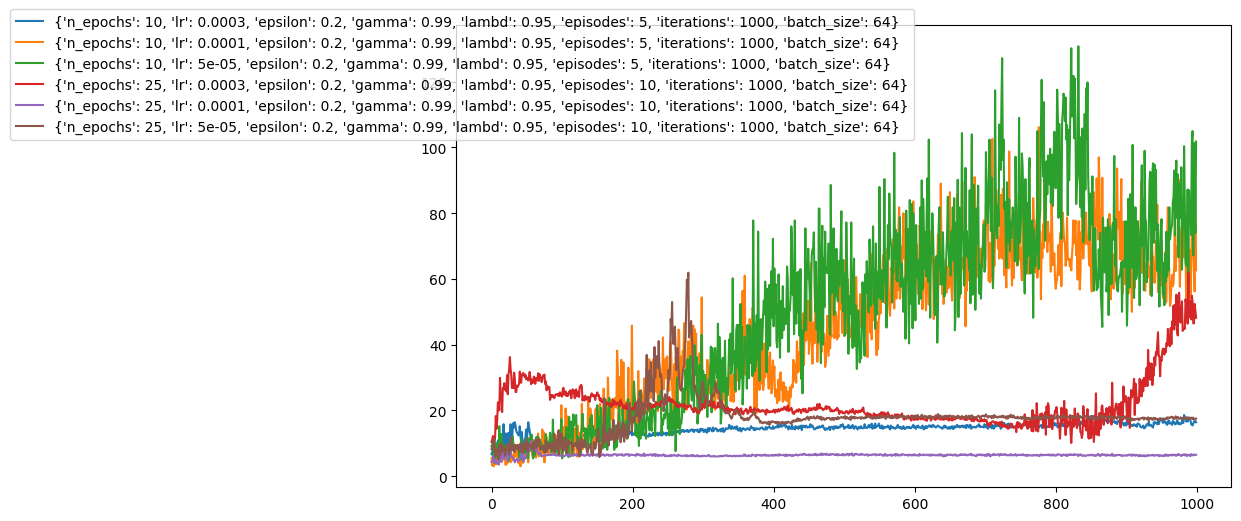

In [336]:
figure = plt.figure(figsize=(10, 6))
for i, performance in enumerate(performances):
    plt.plot(np.arange(len(performance)), performance, label=str(hyperparameters[i]))
plt.legend(bbox_to_anchor=(0.6, 1.05))